In [1]:
import numpy as np
import gymnasium as gym
import torch

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
# The "ipympl" backend is better, as it allows for interactiveness, but on some installations it does not work, then use "inline"
%matplotlib ipympl
# %matplotlib inline  

# this way of importing allow to reload/refresh the module later with importlib.reload(policy)
import policy as policy 
import memory as mem
from feedforward import Feedforward

Load environment, policy and memory.

In [2]:
env = gym.make('Pendulum-v1', g=9.81, render_mode="human")
pi = policy.PDPolicy(env)
buffer = mem.Memory()

## Inspect the environment 

In [3]:
s , _ = env.reset()
for t in range(100):
    a = pi.get_action(s) 
    s_new, rew, term, trunc, _ = env.step(a)
    buffer.add_transition([s,a,rew,s_new, term, trunc])
    s = s_new

/home/meloneneis/miniconda3/envs/hw6/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [4]:
transitions = buffer.get_all_transitions()
states = np.vstack(transitions[:,0])
actions = transitions[:,1]
rewards = transitions[:,2]

Plot the trajectory: (state, action, reward)
 
 The state is [position, velocity] 
 
 **changes are needed**

In [5]:
def plot_trajectory(buffer):
    """Plot a trajectory of the Pendulum system"""
    transitions = buffer.get_all_transitions()
    states = np.vstack(transitions[:,0])
    rewards = transitions[:,2]

    cos_theta = states[:, 0]
    sin_theta = states[:, 1]
    theta_dot = states[:, 2]
    theta = np.arctan2(sin_theta, cos_theta)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    axes[0, 0].plot(theta, 'b-', linewidth=1.5)
    axes[0, 0].set_xlabel('Timestep')
    axes[0, 0].set_ylabel('Angle θ (rad)')
    axes[0, 0].set_title('Pendulum Angle over Time')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    axes[0, 1].plot(theta_dot, 'r-', linewidth=1.5)
    axes[0, 1].set_xlabel('Timestep')
    axes[0, 1].set_ylabel('Angular Velocity θ̇ (rad/s)')
    axes[0, 1].set_title('Angular Velocity over Time')
    axes[0, 1].grid(True)

    axes[1, 0].plot(theta, theta_dot, 'purple', linewidth=0.5, alpha=0.7)
    axes[1, 0].scatter(theta[0], theta_dot[0], color='green', s=100, zorder=5, label='Start')
    axes[1, 0].scatter(theta[-1], theta_dot[-1], color='red', s=100, zorder=5, label='End')
    axes[1, 0].set_xlabel('Angle θ (rad)')
    axes[1, 0].set_ylabel('Angular Velocity θ̇ (rad/s)')
    axes[1, 0].set_title('Phase Space Trajectory')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    axes[1, 1].plot(rewards, 'orange', linewidth=1.5)
    axes[1, 1].set_xlabel('Timestep')
    axes[1, 1].set_ylabel('Reward')
    axes[1, 1].set_title('Reward over Time')
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig("trajectory.png", bbox_inches="tight", dpi=300)

    return fig

/tmp/ipykernel_1268816/1993739528.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 0].legend()


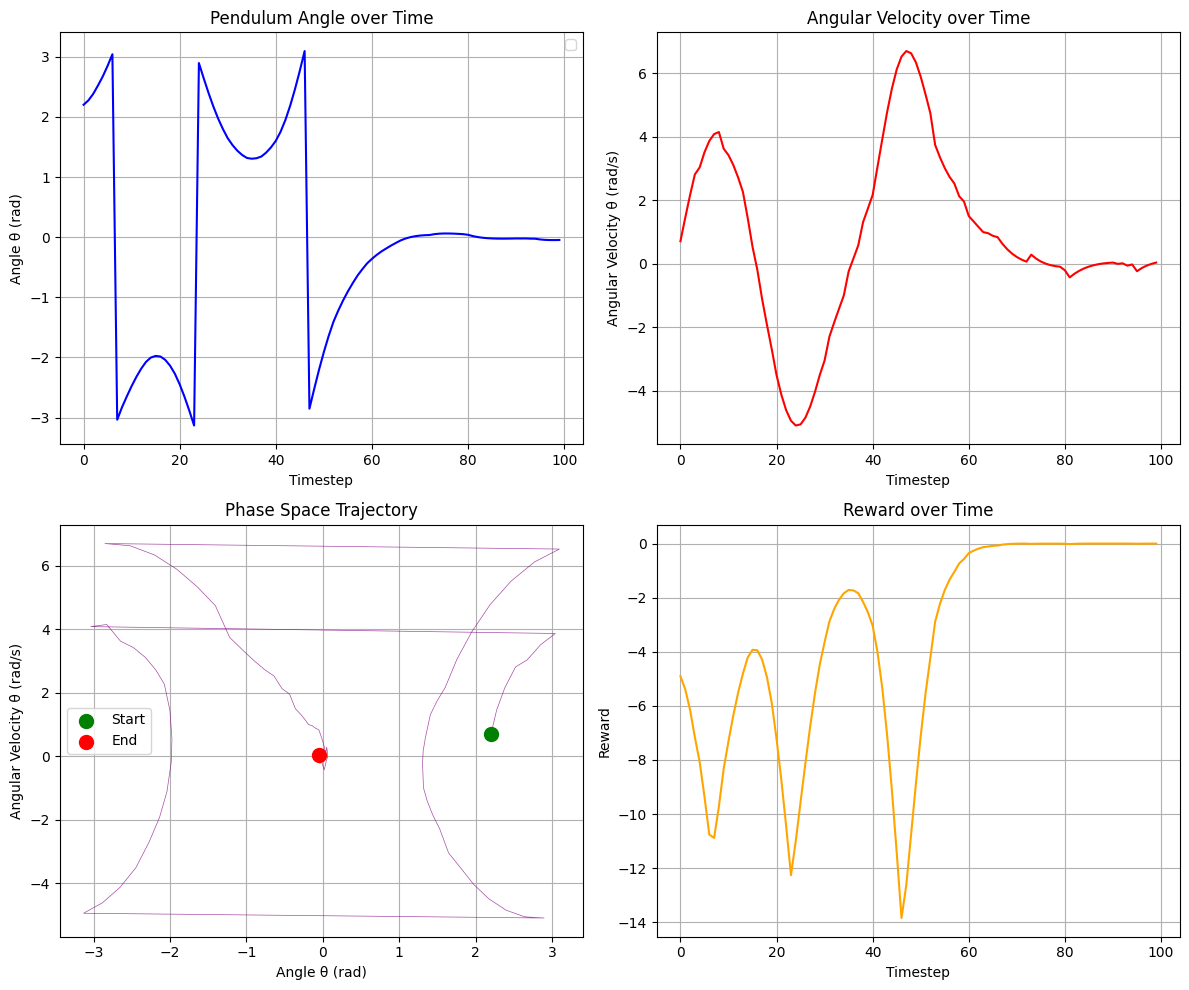

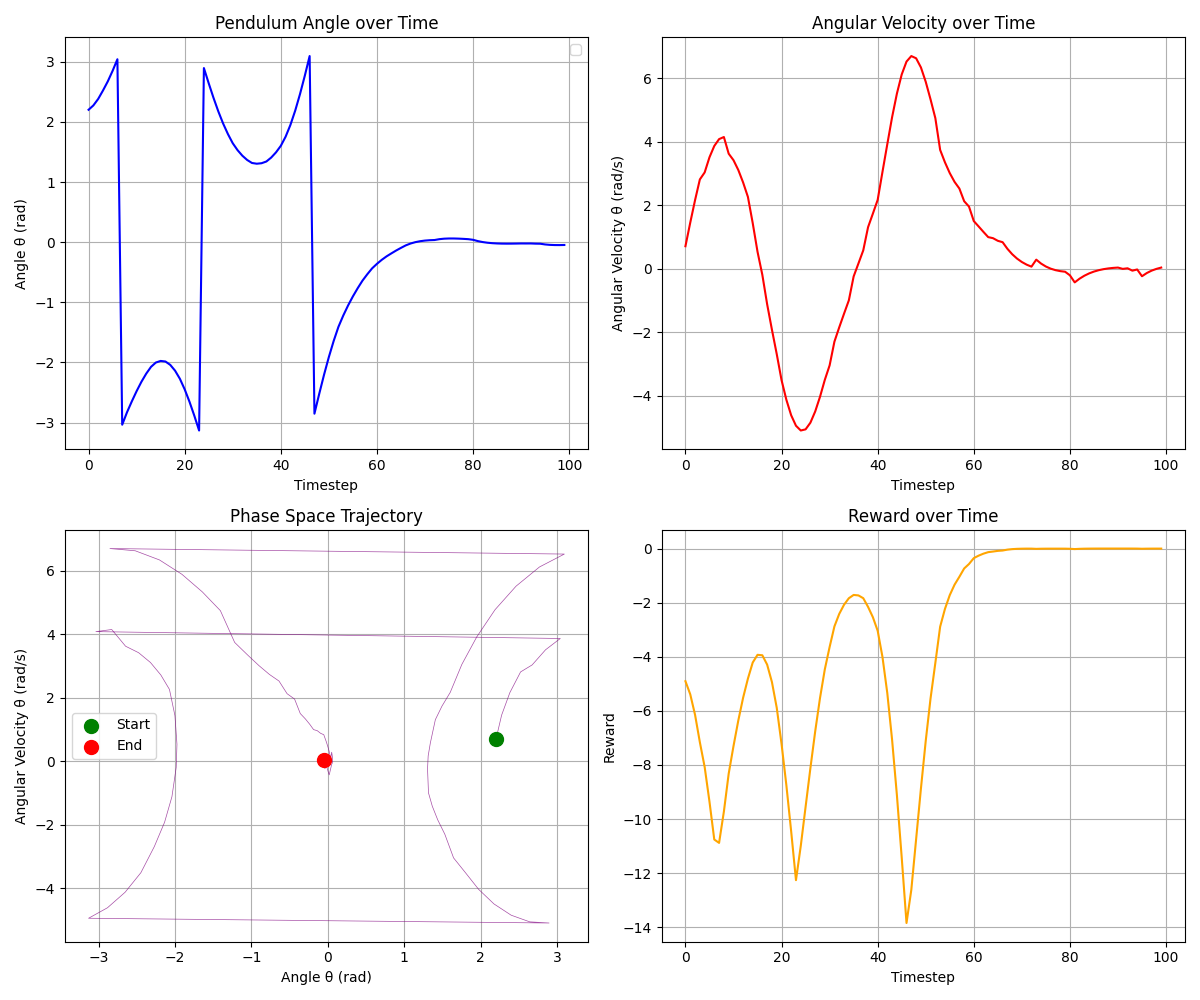

In [6]:
plot_trajectory(buffer)

# Collect data

We do 500 rollouts a 100 timesteps with the black box policy. Nothing needs to be changed here.

In [7]:
env = gym.make('Pendulum-v1', g=9.81, render_mode=None) # switch off rendering
for ep in range(500):
    # start a larger range initial conditions to see enough of the statespace
    s, _ = env.reset(options={"y_init": 4.0})
    for t in range(100):
        a = pi.get_action(s) 
        s_new, rew, term, trunc, _ = env.step(a)
        buffer.add_transition([s,a,rew,s_new, term, trunc])
        s = s_new

In [8]:
buffer.size

50100

# Fit value function

The value function fitting class. Here, you need to fill in the blank parts

In [9]:
class ValueFunction(Feedforward):
    def __init__(self, observation_dim, hidden_sizes=[100, 100]):
        super().__init__(input_size=observation_dim, hidden_sizes=hidden_sizes, output_size=1)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0006, eps=1e-6)
        
        self.loss = torch.nn.MSELoss()
    
    def fit(self, observations, targets):
        self.optimizer.zero_grad()
        
        observations_tensor = torch.from_numpy(observations).float()
        targets_tensor = torch.from_numpy(targets).float()

        if targets_tensor.dim() == 1:
            targets_tensor = targets_tensor.unsqueeze(1)

        predictions = self.forward(observations_tensor)

        loss = self.loss(predictions, targets_tensor)
        
        loss.backward()
        self.optimizer.step()

        return loss.item()

In [10]:
valuefunc = ValueFunction(observation_dim=env.observation_space.shape[0])

Fitting routine of the value function. Fill in the blank parts.

In [11]:
plt_fit = []

valuefunc_before = ValueFunction(observation_dim=env.observation_space.shape[0])

Iteration 200/2000, Loss: 15.880280
Iteration 400/2000, Loss: 14.735420
Iteration 600/2000, Loss: 9.026365
Iteration 800/2000, Loss: 8.346987
Iteration 1000/2000, Loss: 9.974684
Iteration 1200/2000, Loss: 5.514743
Iteration 1400/2000, Loss: 4.025018
Iteration 1600/2000, Loss: 6.303497
Iteration 1800/2000, Loss: 4.012668
Iteration 2000/2000, Loss: 8.614472


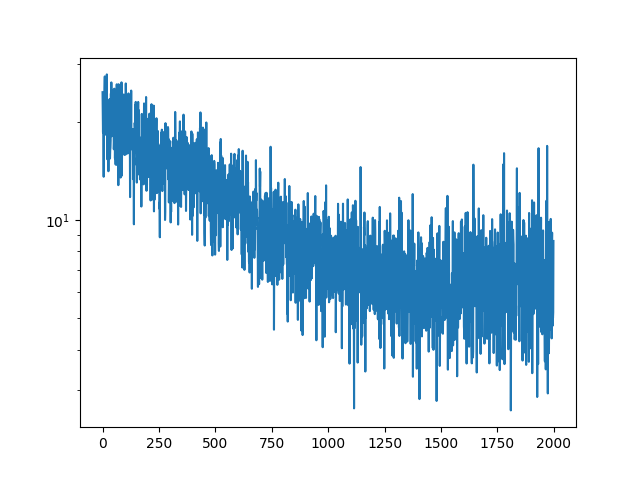

In [12]:
iter_fit = 2000 # do at least 2000
gamma=0.95
for i in range(iter_fit):

    # sample from the replay buffer
    data=buffer.sample(batch=128)
    # each entry in data is (state,action,reward,next_state, term, trunc)    
    
    # Hints:
    #  use can use np.stack to convert the array or arrays into one array
    #  it is really important that you check the shapes of your arrays.
    #  It should be (128,2) for the state and (128,1) for reward and values
    
    state = np.stack([d[0] for d in data])

    rewards = np.array([d[2] for d in data])

    next_states = np.stack([d[3] for d in data])

    terminals = np.array([d[4] for d in data])
    
    next_states_tensor = torch.from_numpy(next_states).float()
    with torch.no_grad():
        next_values = valuefunc.forward(next_states_tensor).squeeze().numpy()
    
    td_target = rewards + gamma * next_values * (1 - terminals)

    # optimize the least squared objective
    fit_loss = valuefunc.fit(state, td_target)

    if (i + 1) % 200 == 0:
            print(f"Iteration {i+1}/{iter_fit}, Loss: {fit_loss:.6f}")
    
    plt_fit.append(fit_loss)
    
# plot the loss
plt.figure()
plt.yscale("log")
plt.plot(range(len(plt_fit)),plt_fit)
plt.savefig("learning_curve_gamma095.png", bbox_inches="tight", dpi=300)

# Visualize

Visualization of the value function. Nothing needs to be changed here.

In [13]:
def plot_value_function(value_function):
    plt.rcParams.update({'font.size': 12})
    xxs =np.linspace(-np.pi/2,np.pi/2)
    yys =np.linspace(-3,3)
    XX,YY=np.meshgrid(xxs,yys)
    dots=np.asarray([np.cos(XX.ravel()),np.sin(XX.ravel()),YY.ravel()]).T
    print(dots.shape)
    # values = np.asarray(test_func(dots)).reshape(XX.shape)
    values =value_function.predict(dots).reshape(XX.shape)

    fig = plt.figure(figsize=[10,8])
    ax = fig.add_subplot(projection='3d')
    surf = ax.plot_surface(XX, YY, values, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.view_init(elev=30, azim=45, roll=0)
    ax.set_xlabel('angle')
    ax.set_ylabel('angle velocity')
    ax.set_zlabel('value')
    # plt.colorbar(cmap=cm.coolwarm)
    return fig

In [14]:
def plot_value_comparison(valuefunc_before, valuefunc_after):
    """Plot value function before and after learning"""

    plt.rcParams.update({'font.size': 12})
    xxs = np.linspace(-np.pi/2, np.pi/2, 50)
    yys = np.linspace(-3, 3, 50)
    XX, YY = np.meshgrid(xxs, yys)


    dots = np.asarray([np.cos(XX.ravel()), np.sin(XX.ravel()), YY.ravel()]).T

    values_before = valuefunc_before.predict(dots).reshape(XX.shape)
    values_after = valuefunc_after.predict(dots).reshape(XX.shape)

    fig = plt.figure(figsize=(16, 6))

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    surf1 = ax1.plot_surface(XX, YY, values_before, cmap=cm.coolwarm,
                             linewidth=0, antialiased=False)
    ax1.view_init(elev=30, azim=45)
    ax1.set_xlabel('Angle θ')
    ax1.set_ylabel('Angular Velocity θ̇')
    ax1.set_zlabel('Value')
    ax1.set_title('Value Function BEFORE Learning')

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    surf2 = ax2.plot_surface(XX, YY, values_after, cmap=cm.coolwarm,
                             linewidth=0, antialiased=False)
    ax2.view_init(elev=30, azim=45)
    ax2.set_xlabel('Angle θ')
    ax2.set_ylabel('Angular Velocity θ̇')
    ax2.set_zlabel('Value')
    ax2.set_title('Value Function AFTER Learning (γ=0.95)')

    plt.tight_layout()
    plt.savefig("value_comparison.png", bbox_inches="tight", dpi=300)
    plt.show()

    return fig

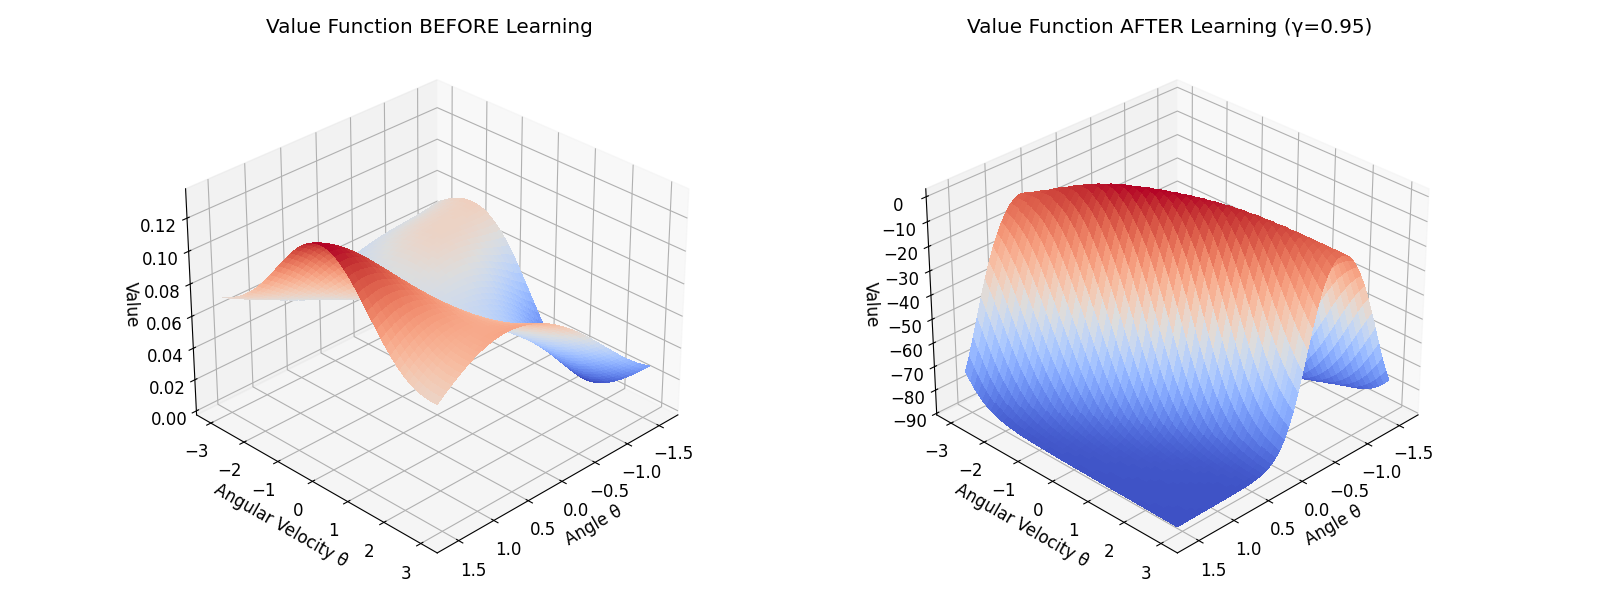

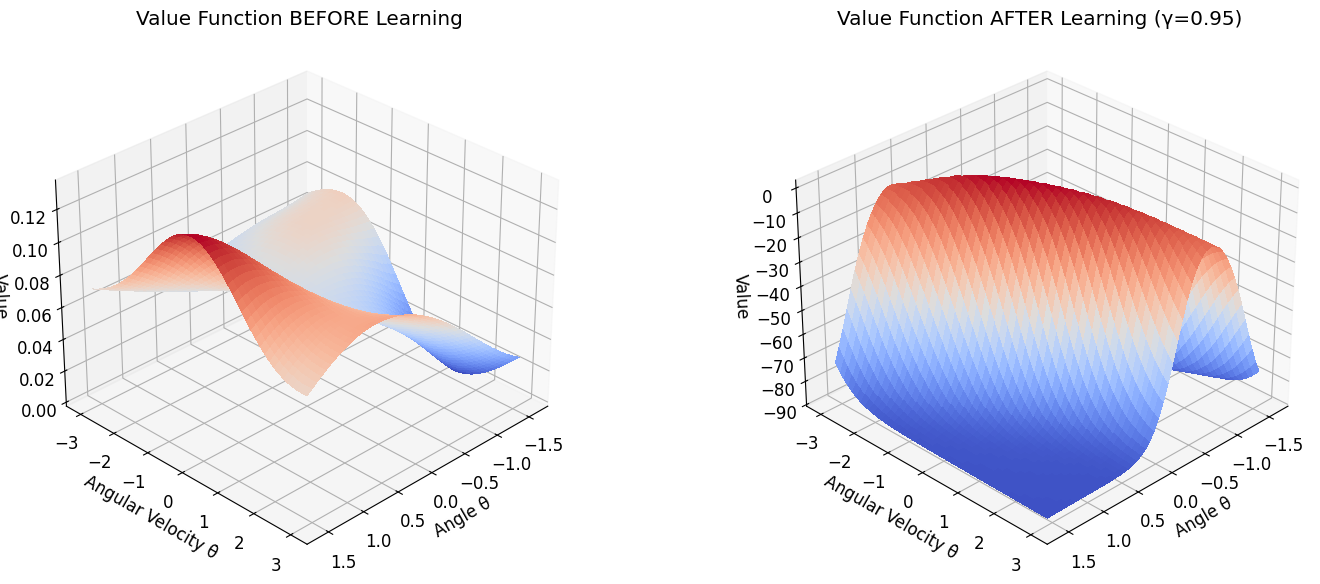

In [15]:
plot_value_comparison(valuefunc_before, valuefunc)

(2500, 3)


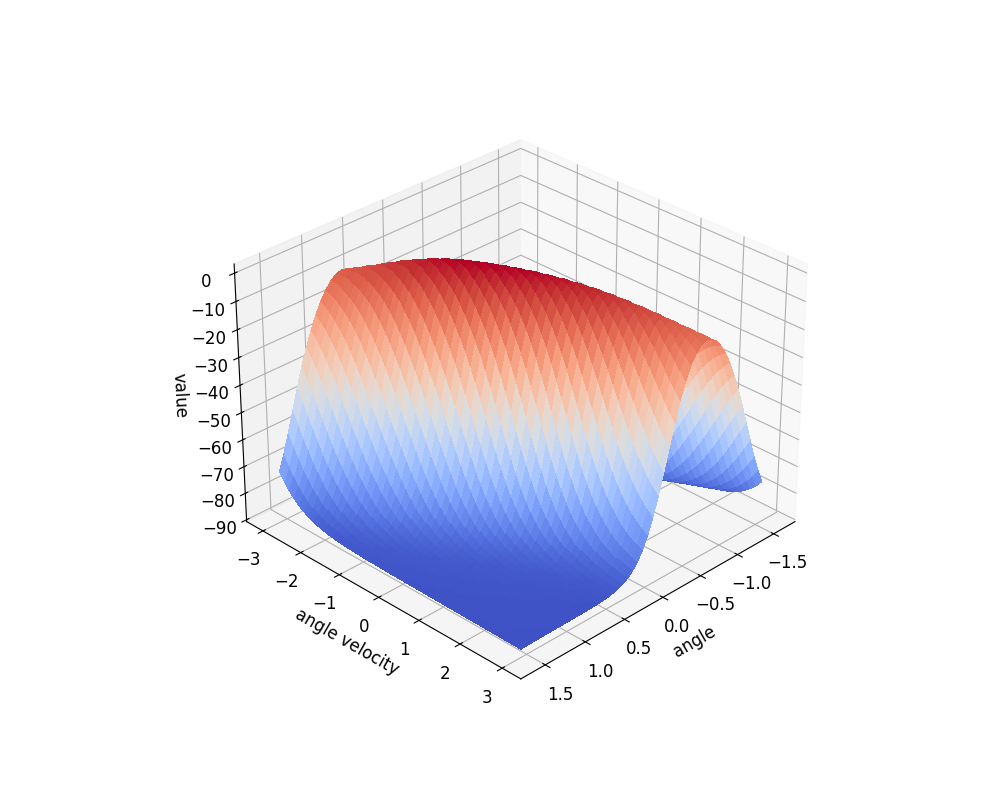

In [16]:
fig = plot_value_function(valuefunc)

fig.savefig("value_approx.png", bbox_inches="tight", dpi=300)

# Comparison with gamma=0.5

Iteration 200/2000, Loss: 3.372032
Iteration 400/2000, Loss: 0.606412
Iteration 600/2000, Loss: 0.100155
Iteration 800/2000, Loss: 0.211941
Iteration 1000/2000, Loss: 0.079069
Iteration 1200/2000, Loss: 0.082588
Iteration 1400/2000, Loss: 0.043099
Iteration 1600/2000, Loss: 0.069412
Iteration 1800/2000, Loss: 0.031543
Iteration 2000/2000, Loss: 0.022839


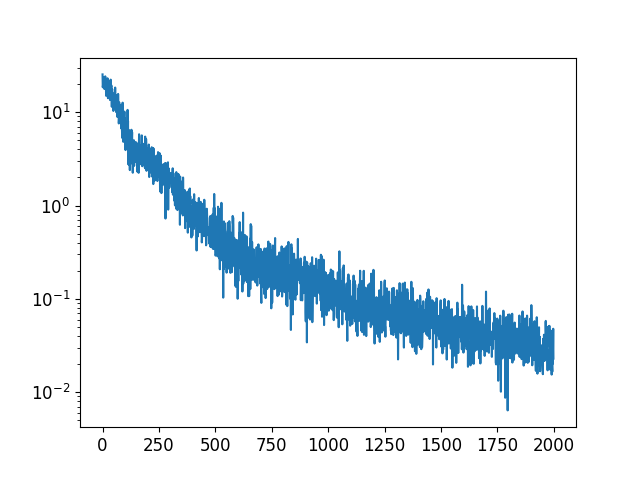

In [17]:
# Train with gamma=0.5
plt_fit_gamma05 = []
valuefunc_gamma05 = ValueFunction(observation_dim=env.observation_space.shape[0])

iter_fit = 2000
gamma = 0.5

for i in range(iter_fit):
    data = buffer.sample(batch=128)

    state = np.stack([d[0] for d in data])
    rewards = np.array([d[2] for d in data])
    next_states = np.stack([d[3] for d in data])
    terminals = np.array([d[4] for d in data])

    next_states_tensor = torch.from_numpy(next_states).float()
    with torch.no_grad():
        next_values = valuefunc_gamma05.forward(next_states_tensor).squeeze().numpy()

    td_target = rewards + gamma * next_values * (1 - terminals)

    fit_loss = valuefunc_gamma05.fit(state, td_target)

    if (i + 1) % 200 == 0:
        print(f"Iteration {i+1}/{iter_fit}, Loss: {fit_loss:.6f}")

    plt_fit_gamma05.append(fit_loss)

# plot the loss
plt.figure()
plt.yscale("log")
plt.plot(range(len(plt_fit_gamma05)),plt_fit_gamma05)
plt.savefig("learning_curve_gamma05.png", bbox_inches="tight", dpi=300)

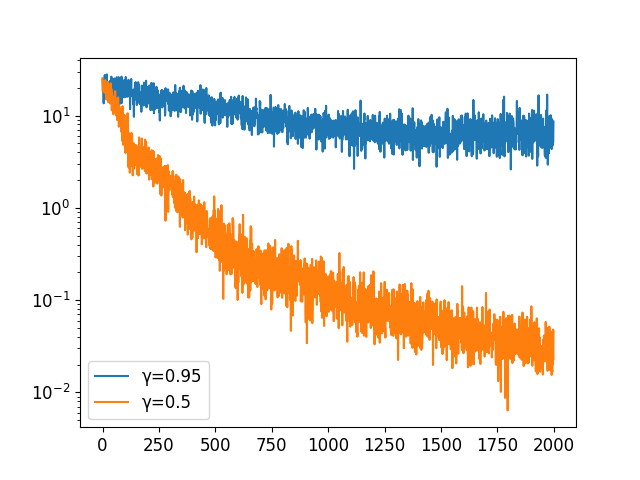

In [18]:
# Compare learning curves
plt.figure()
plt.yscale("log")
plt.plot(range(len(plt_fit)), plt_fit, label='γ=0.95')
plt.plot(range(len(plt_fit_gamma05)), plt_fit_gamma05, label='γ=0.5')
plt.legend()
plt.savefig("learning_curve_comparison.png", bbox_inches="tight", dpi=300)

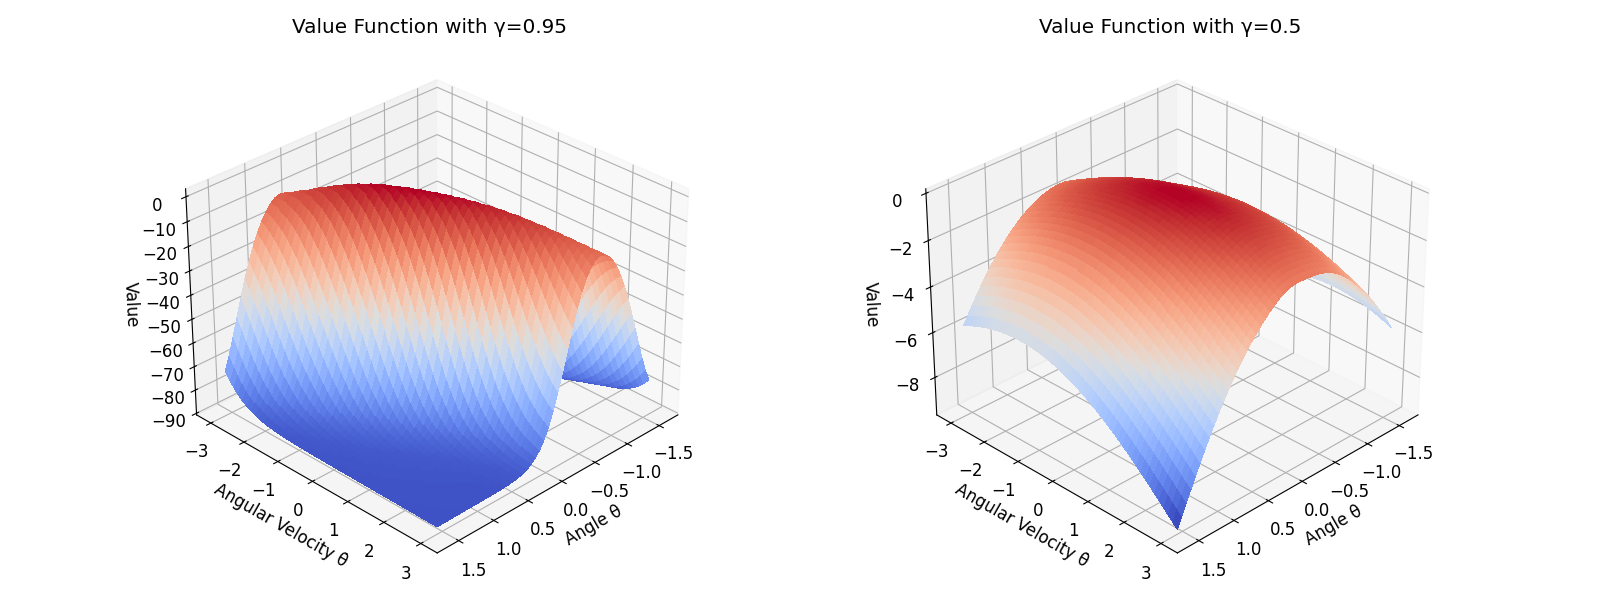

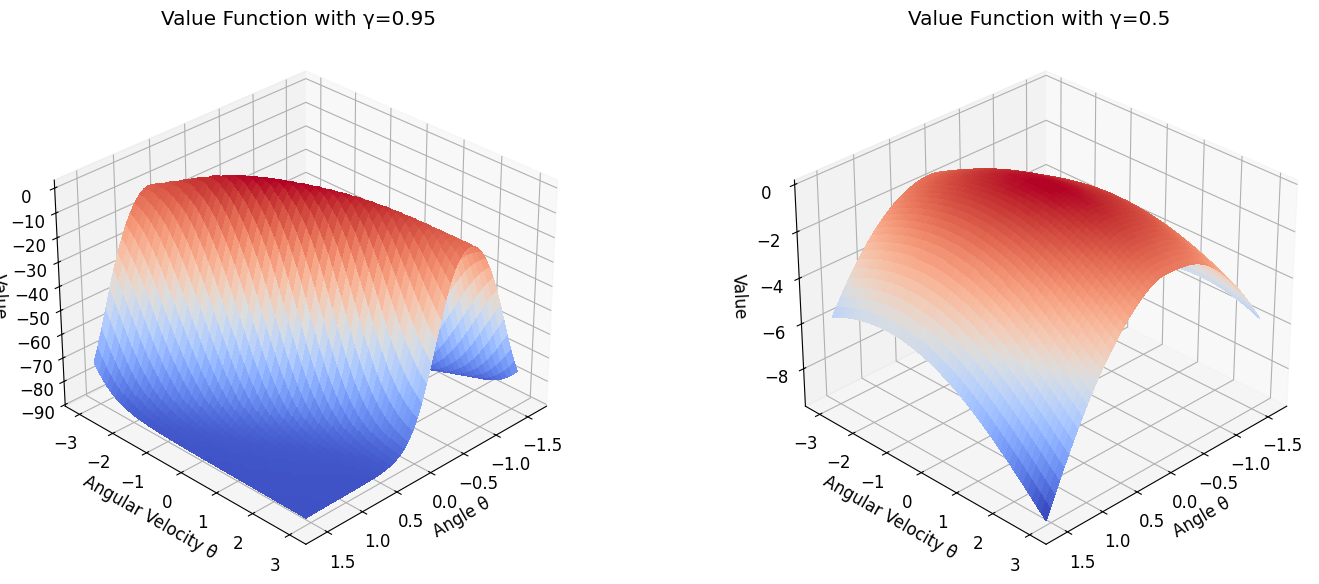

In [19]:
# Compare value functions
def plot_gamma_comparison(valuefunc_095, valuefunc_05):
    """Compare value functions with different gamma values"""

    plt.rcParams.update({'font.size': 12})
    xxs = np.linspace(-np.pi/2, np.pi/2, 50)
    yys = np.linspace(-3, 3, 50)
    XX, YY = np.meshgrid(xxs, yys)

    dots = np.asarray([np.cos(XX.ravel()), np.sin(XX.ravel()), YY.ravel()]).T

    values_095 = valuefunc_095.predict(dots).reshape(XX.shape)
    values_05 = valuefunc_05.predict(dots).reshape(XX.shape)

    fig = plt.figure(figsize=(16, 6))

    # Plot gamma=0.95
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    surf1 = ax1.plot_surface(XX, YY, values_095, cmap=cm.coolwarm,
                             linewidth=0, antialiased=False)
    ax1.view_init(elev=30, azim=45)
    ax1.set_xlabel('Angle θ')
    ax1.set_ylabel('Angular Velocity θ̇')
    ax1.set_zlabel('Value')
    ax1.set_title('Value Function with γ=0.95')

    # Plot gamma=0.5
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    surf2 = ax2.plot_surface(XX, YY, values_05, cmap=cm.coolwarm,
                             linewidth=0, antialiased=False)
    ax2.view_init(elev=30, azim=45)
    ax2.set_xlabel('Angle θ')
    ax2.set_ylabel('Angular Velocity θ̇')
    ax2.set_zlabel('Value')
    ax2.set_title('Value Function with γ=0.5')

    plt.tight_layout()
    plt.savefig("gamma_comparison.png", bbox_inches="tight", dpi=300)
    plt.show()

    return fig

plot_gamma_comparison(valuefunc, valuefunc_gamma05)